In [1]:
import scanpy as sc
import glob
import os
from functools import reduce
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import importlib
from sctools import qc, plot

## Quality control of raw data

In [6]:
adata = sc.read_h5ad(
    '../data/inflammatory_disease.h5ad'
)
# remove UC, atopic dermatitis, pbmcs and doublets
adata = adata[
    adata.obs.sample_id.str.startswith('GSM') &
    adata.obs.tissue.str.startswith('PBMC')
].copy()
adata

AnnData object with n_obs × n_vars = 112097 × 33538
    obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score'

In [7]:
qc.compute_qc_metrics(adata)

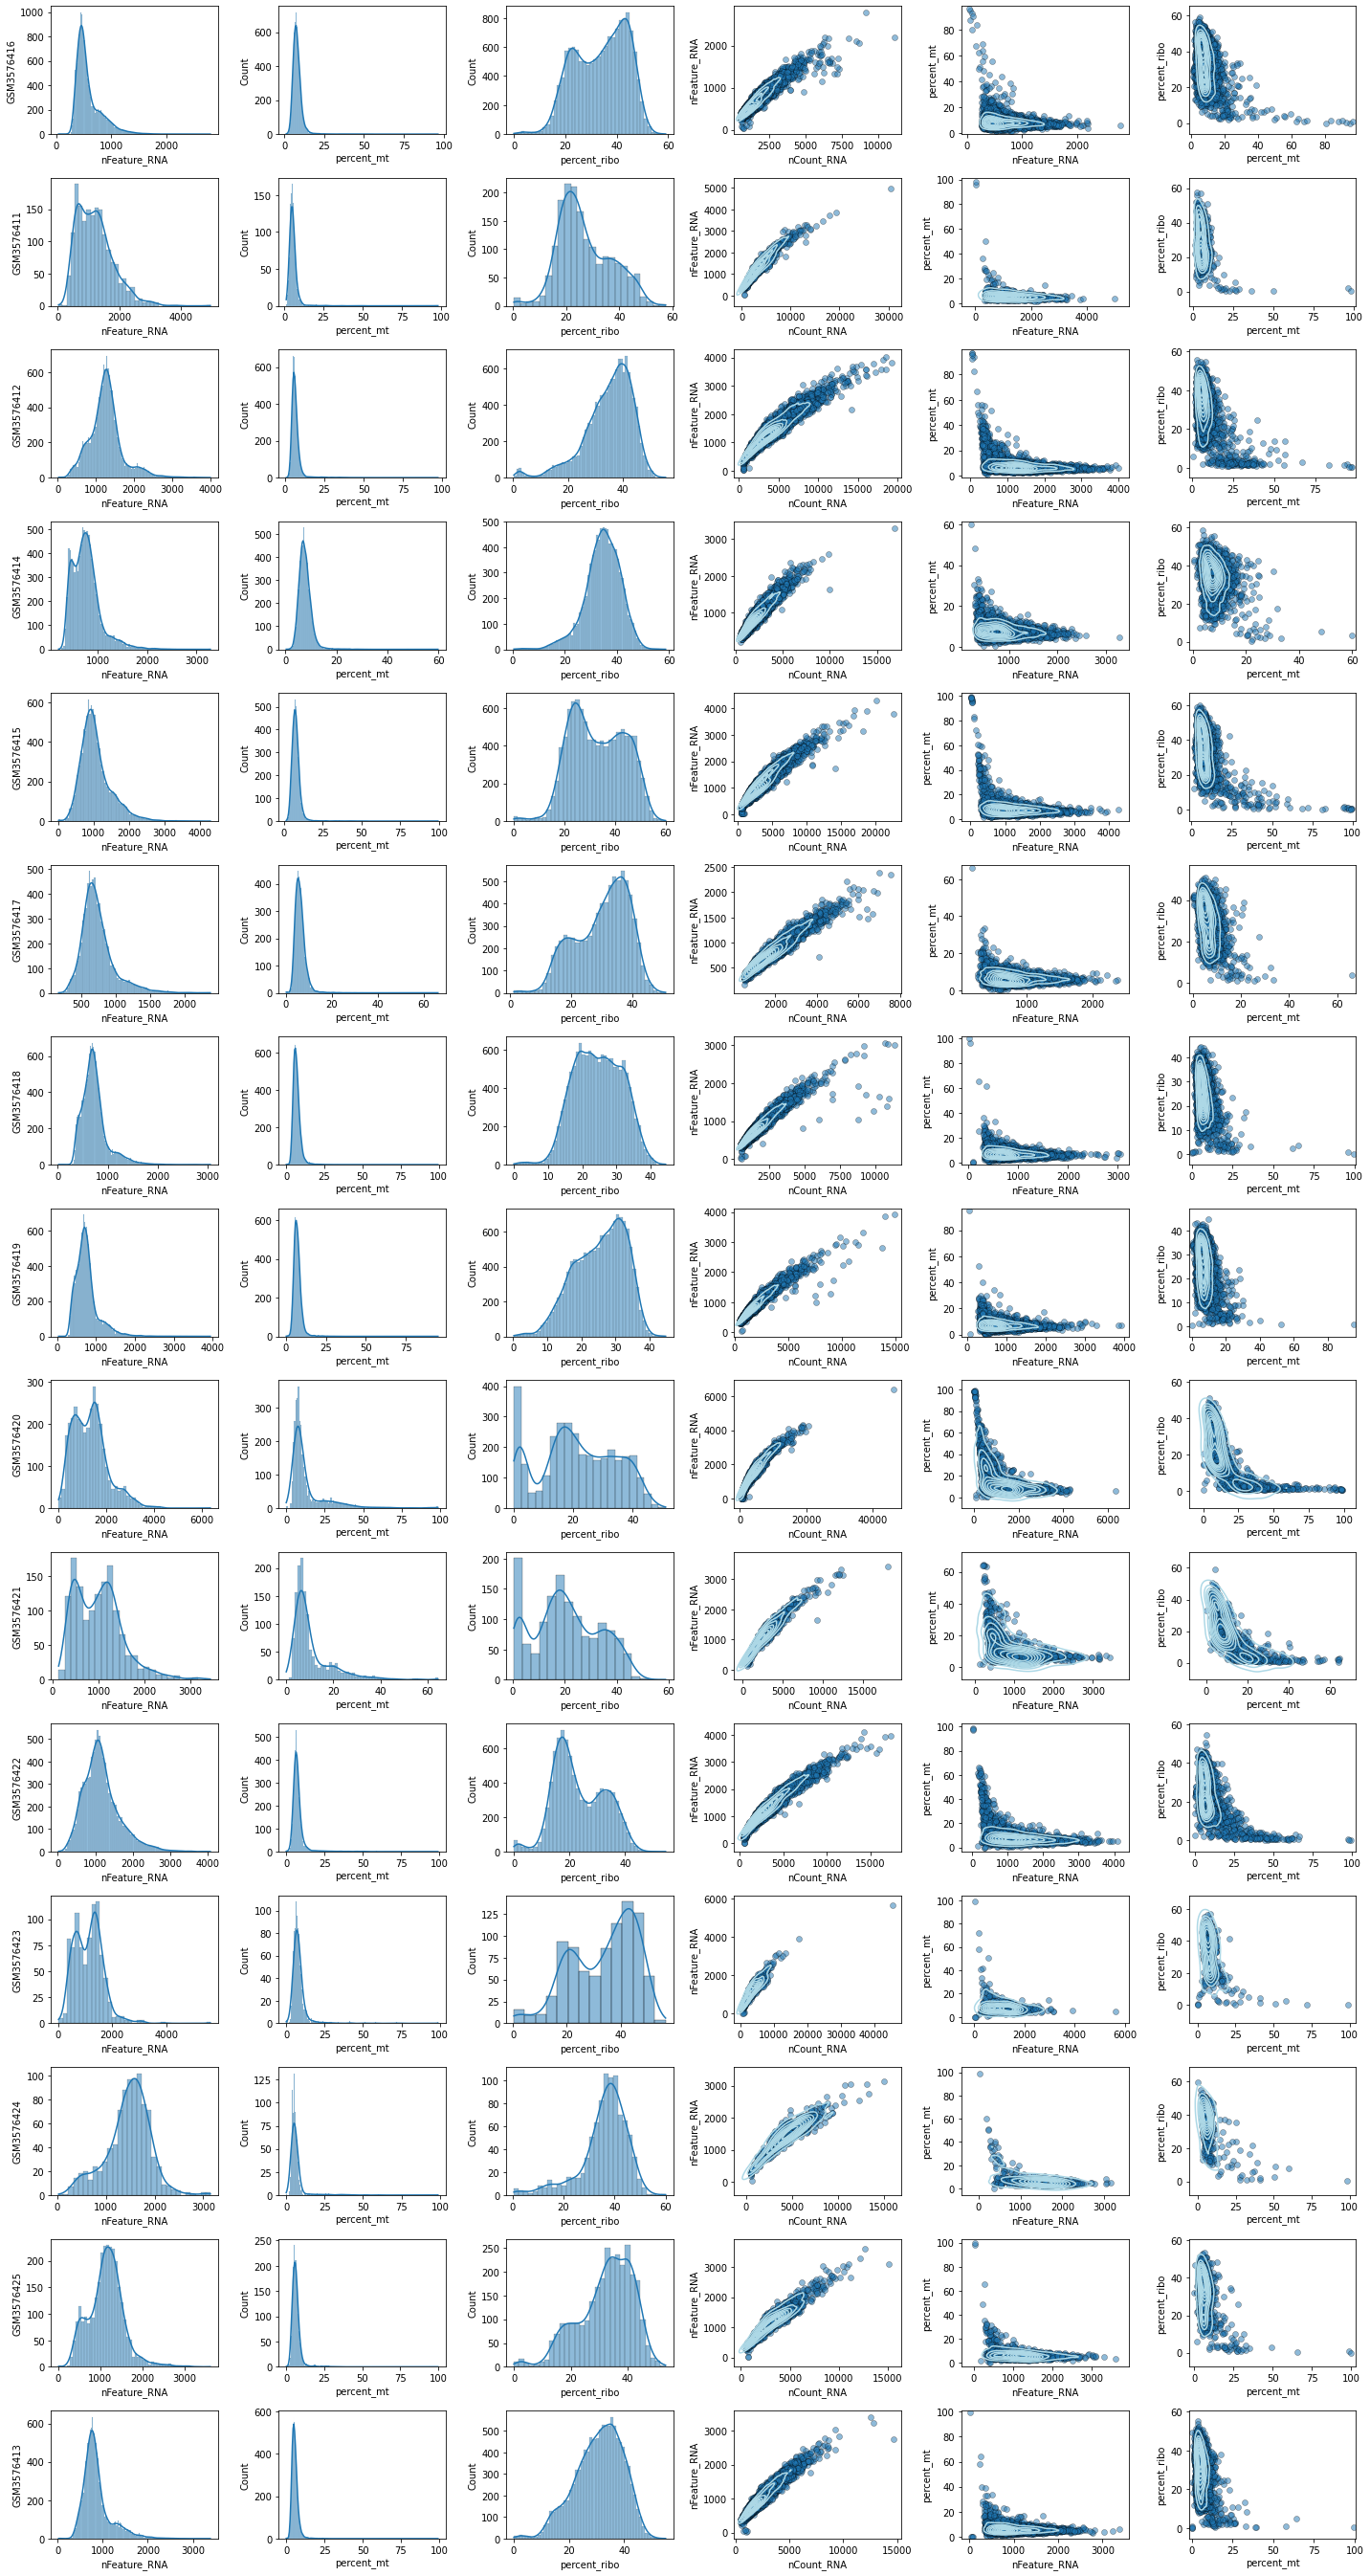

In [8]:
fig = plot.qc.plot_qc(
    adata,
    sample_id_column = 'sample_id'
)
fig.set_figwidth(20)
fig.set_figheight(adata.obs.sample_id.nunique() * 2.5)
fig.tight_layout()

In [13]:
MIN_RNA_FEATURES = 500
MAX_RNA_FEATURES = 5000
MAX_PERCENT_MT = 15

qc_thresholds = {
    k: {
        'nFeature_RNA': (MIN_RNA_FEATURES, MAX_RNA_FEATURES), 
        'percent_mt': (0, MAX_PERCENT_MT), 
        'percent_ribo': (5, 100)
    } 
    for k 
    in adata.obs.sample_id
}

try:
    assert len(qc_thresholds) == adata.obs.sample_id.nunique()
    
except AssertionError:
    print('qc_threshold does not have the same length as there are unique sample_ids! Please make sure all sample_ids are in qc_thresholds!')
    raise AssertionError
    
try:
    assert all(x in qc_thresholds for x in adata.obs.sample_id.unique())
    
except AssertionError:
    print(
        [x for x in adata.obs.sample_id.unique() if not x in qc_thresholds], 
        'are missing from qc_thresholds! Please check your code!'
    )
    raise AssertionError

qc.apply_qc_thresholds(
    adata, 
    'sample_id', 
    qc_thresholds
)
ncells = adata.obs.shape[0]
nfiltered = ncells - adata.obs.qc_pass.sum()
print(
    f'{nfiltered} of {ncells} cells would be removed using the current qc thresholds'
)

17635 of 112097 cells would be removed using the current qc thresholds


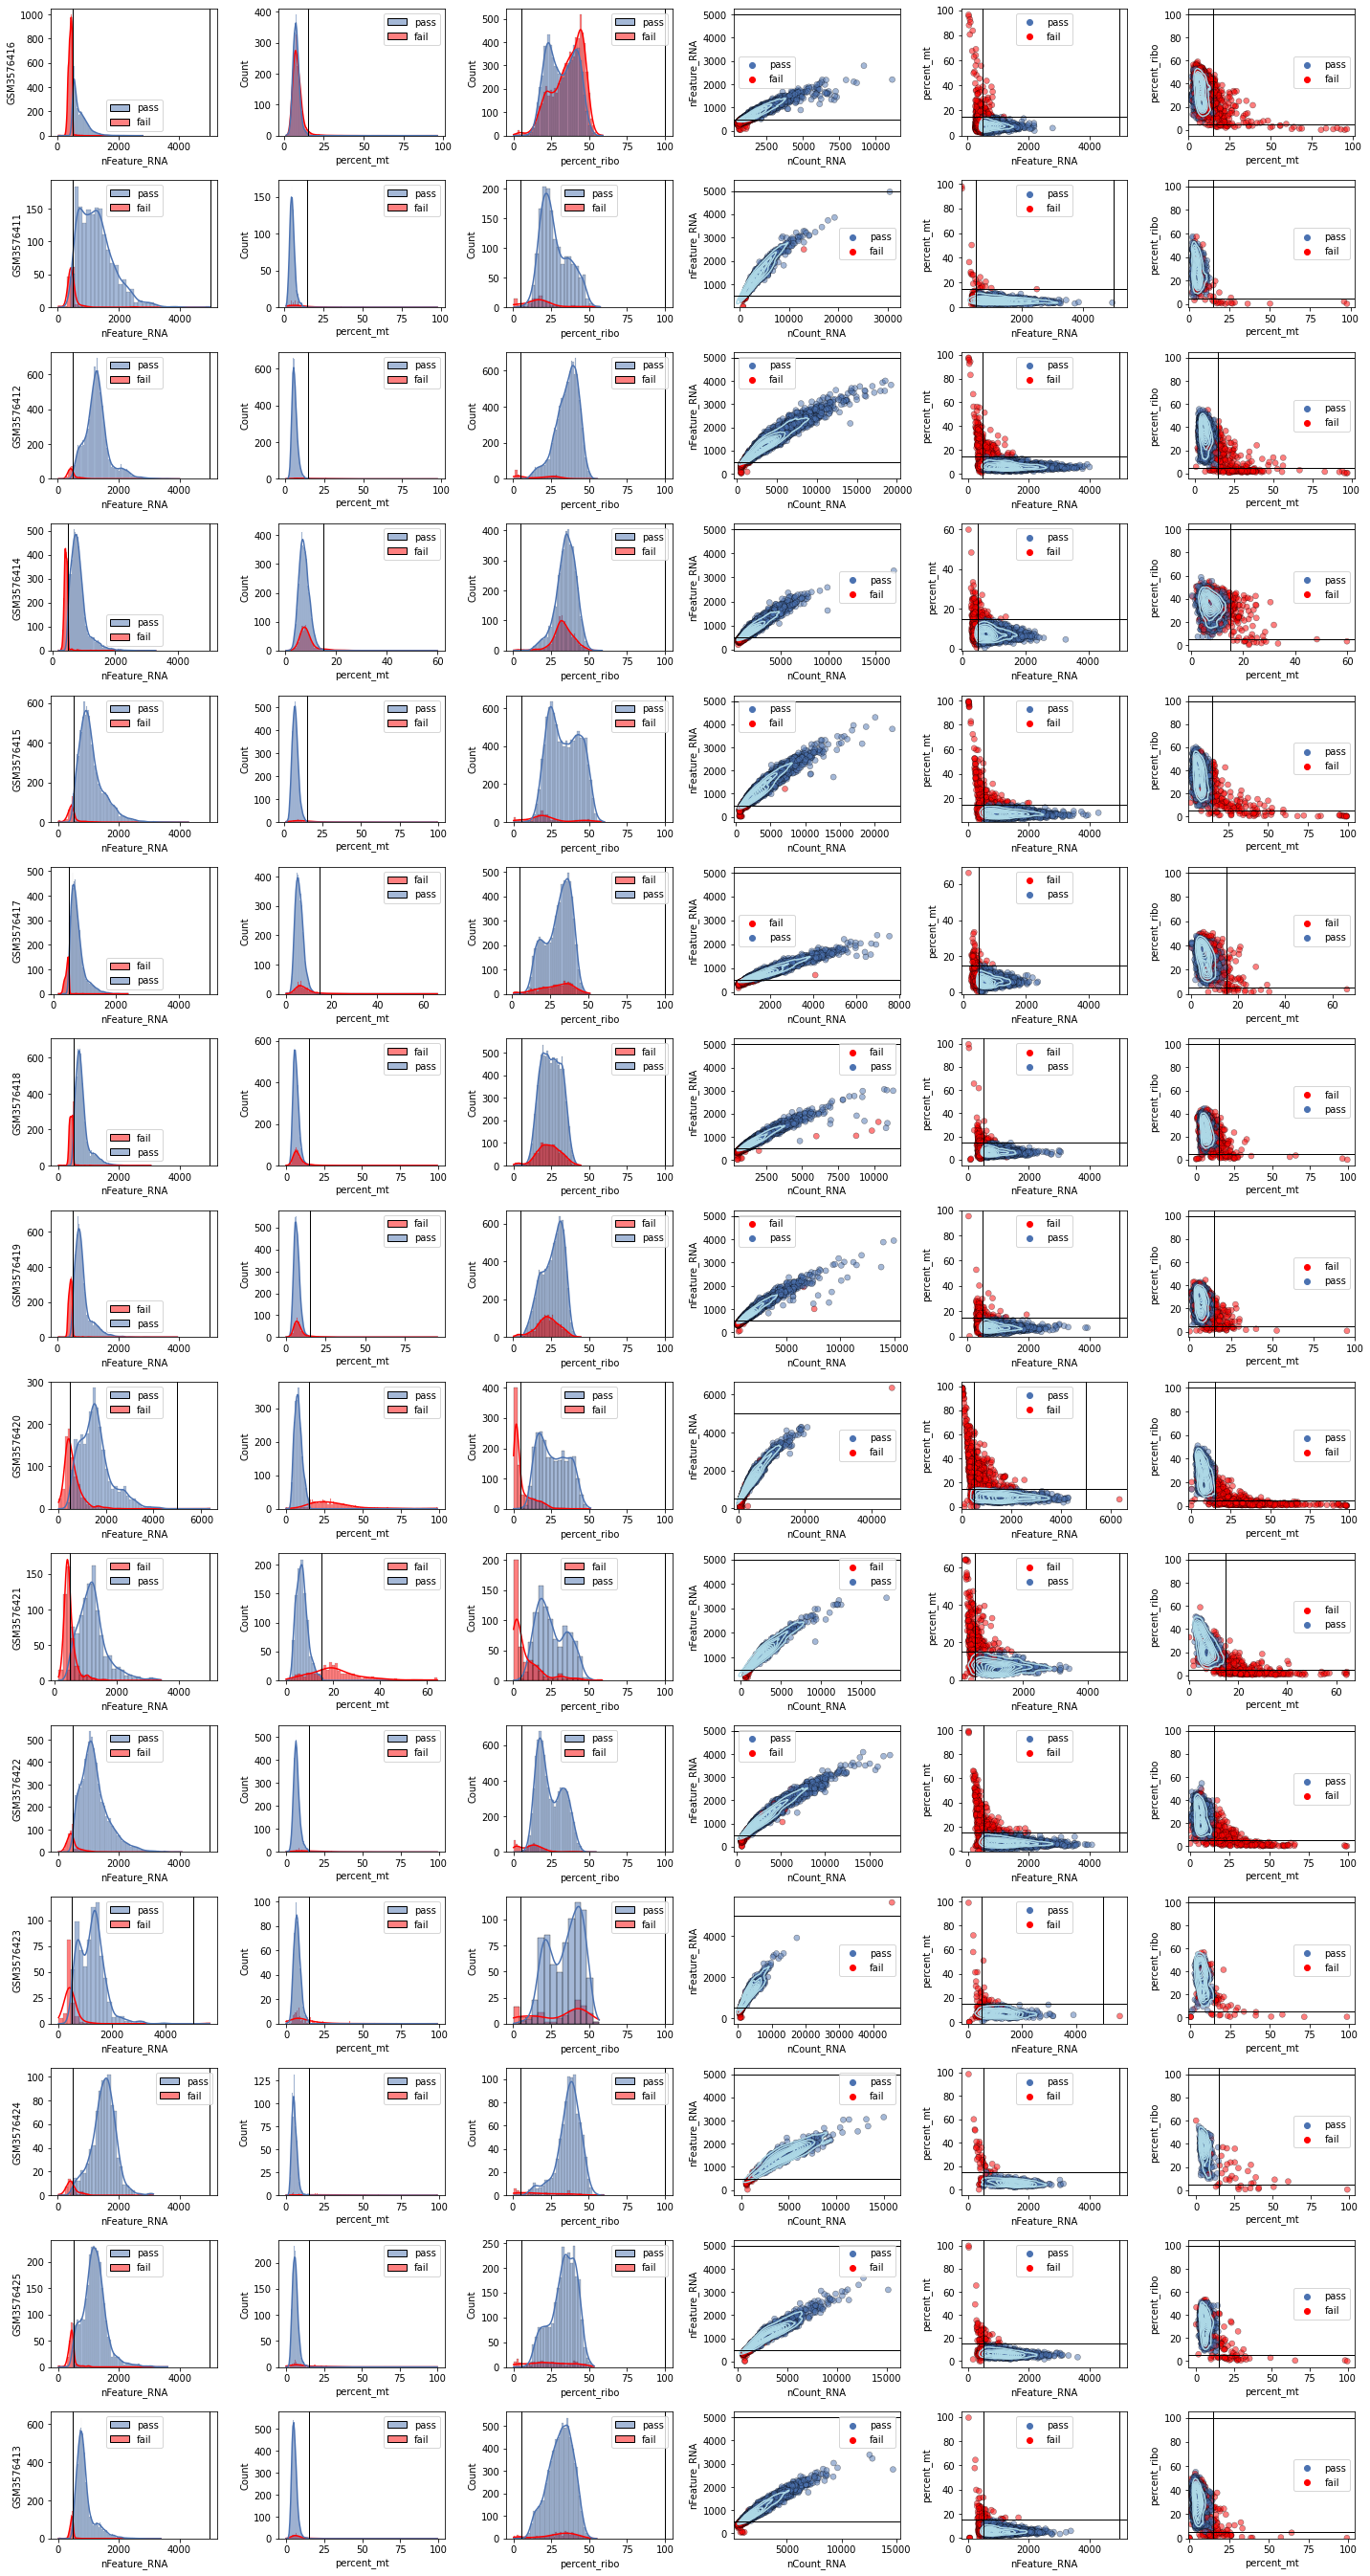

In [14]:
fig = plot.qc.plot_qc(
    adata,
    thresholds = qc_thresholds,
    sample_id_column = 'sample_id'
)
fig.set_figwidth(20)
fig.set_figheight(adata.obs.sample_id.nunique() * 2.5)
fig.tight_layout()

In [15]:
# apply qc filter
adata = adata[adata.obs.qc_pass, :].copy()

In [18]:
# filter genes
nexpressed_threshold = 50
ngenes_passed = (qc.get_nexpressed(adata) >= nexpressed_threshold).sum()
ngenes = adata.var.shape[0]
print(
    f'{ngenes_passed} of {ngenes} are retained requiring their expression in {nexpressed_threshold} or more cells'
)

15435 of 33538 are retained requiring their expression in 50 or more cells


In [19]:
adata = adata[:, (qc.get_nexpressed(adata) >= nexpressed_threshold)].copy()

In [20]:
adata.write(
    '../data/pbmc.uc.qcfiltered.h5ad'
)